In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

In [2]:
tickers = ['SPY', 'QQQ', 'AAPL', 'MSFT']

In [3]:
def get_data(tickers):
    
    data_dict = {}
    
    for ticker in tickers:
        
        data = yf.download(tickers=ticker, start = '2012-03-11', end = '2022-07-10').reset_index(drop=False)[['Date', 'Open', 'Close']]
        data['Target'] = data['Close'].shift(-1)
        data = data.set_index('Date').dropna()

        data_dict[f'{ticker}_df'] = data
        
        
    return data_dict

In [5]:
def get_lin_reg(data_dict):
    
    pred_dict = {}
    
    for key in data_dict.keys():
        
        ticker_df = data_dict[key]
        
        features = ticker_df.drop('Target', axis=1)
        target = ticker_df['Target']
        
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.2, shuffle=False)
        
        model = LinearRegression()
        
        model.fit(X_train, y_train)
        
        pred = model.predict(X_test)
        
        pred_df = y_test.reset_index(drop=False)
        pred_df['Predictions'] = pred
        
        residual = y_test-pred
        residual_df = residual.reset_index(drop=False)

        ticker = key.split('_')[0]

        pred_dict[f'{ticker}'] = [pred_df, residual_df]
        
    return pred_dict

def get_kfold_lin_reg(data_dict, num_folds=5):
    pred_dict = {}

    for key in data_dict.keys():
        ticker_df = data_dict[key]

        features = ticker_df.drop('Target', axis=1)
        target = ticker_df['Target']

        kf = KFold(n_splits=num_folds, shuffle=False)

        pred_list = []
        residual_list = []

        for train_index, test_index in kf.split(features):
            X_train, X_test = features.iloc[train_index], features.iloc[test_index]
            y_train, y_test = target.iloc[train_index], target.iloc[test_index]

            model = LinearRegression()
            model.fit(X_train, y_train)
            pred = model.predict(X_test)

            pred_list.extend(pred)
            residual_list.extend(y_test - pred)

        pred_df = pd.DataFrame({'Target': target, 'Predictions': pred_list, 'Residuals': residual_list}).reset_index(drop=False)

        ticker = key.split('_')[0]
        pred_dict[f'{ticker}'] = pred_df

    return pred_dict


In [6]:
def get_poly_reg(data_dict, degree):
    
    pred_dict = {}
    
    for key in data_dict.keys():
        
        ticker_df = data_dict[key]
        
        features = [col for col in ticker_df.columns if col != 'Target']
        target = 'Target'
        
        poly_features = PolynomialFeatures(degree=degree)
        
        X = poly_features.fit_transform(ticker_df[features])
        y = ticker_df[target]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=False)
        
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        pred = model.predict(X_test)
        
        pred_df = y_test.reset_index(drop=False)
        pred_df['Predictions'] = pred
        
        residual = y_test - pred
        residual_df = residual.reset_index(drop=False)
        
        ticker = key.split('_')[0]
        
        pred_dict[f'{ticker}'] = [pred_df, residual_df]
        
    return pred_dict
        
        

In [14]:
def plot_pred(pred_dict, type_of_reg):
    
    for ticker in pred_dict.keys():
        
        pred_df, residual_df = pred_dict[ticker]
        
        plt.figure(figsize=(6,4))
        plt.plot(pred_df['Date'], pred_df['Target'], label = 'Actual', color = 'green')
        plt.plot(pred_df['Date'], pred_df['Predictions'], label='Pred', color = 'red')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'{ticker} {type_of_reg} Regression')
        plt.legend()
        plt.xticks(rotation=45)
        
        plt.figure(figsize=(6,4))
        plt.scatter(residual_df['Date'], residual_df['Target'], label='Residuals', color = 'blue')
        plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='y=0')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'{ticker} {type_of_reg} Residuals')
        plt.legend()
        plt.xticks(rotation=45)
        
        plt.show()

In [8]:
def plot_kfold_pred(pred_dict, type_of_reg):
    
    
    for ticker in pred_dict.keys():
        
        pred_df = pred_dict[ticker]
        
        plt.figure(figsize=(6,4))
        plt.plot(pred_df['Date'], pred_df['Target'], label = 'Actual', color = 'green')
        plt.plot(pred_df['Date'], pred_df['Predictions'], label='Pred', color = 'red')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'{ticker} {type_of_reg} Regression')
        plt.legend()
        plt.xticks(rotation=45)
        
        plt.figure(figsize=(6,4))
        plt.scatter(pred_df['Date'], pred_df['Residuals'], label='Residuals', color = 'blue')
        plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='y=0')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'{ticker} {type_of_reg} Residuals')
        plt.legend()
        plt.xticks(rotation=45)
        
        plt.show()

In [9]:
data = get_data(tickers)
lin_pred = get_lin_reg(data)
kfold_lin_pred = get_kfold_lin_reg(data)
poly_pred = get_poly_reg(data, 2)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [10]:
data['SPY_df']

,Open,Close,Target
Date,,,
2012-03-12,137.550003,137.580002,140.059998
2012-03-13,138.320007,140.059998,139.910004
2012-03-14,140.100006,139.910004,140.720001
2012-03-15,140.119995,140.720001,140.300003
2012-03-16,140.360001,140.300003,140.850006
...,...,...,...
2022-06-30,376.239990,377.250000,381.239990
2022-07-01,376.559998,381.239990,381.959991
2022-07-05,375.880005,381.959991,383.250000


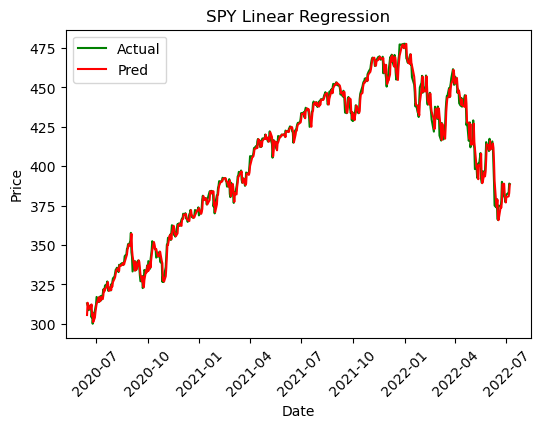

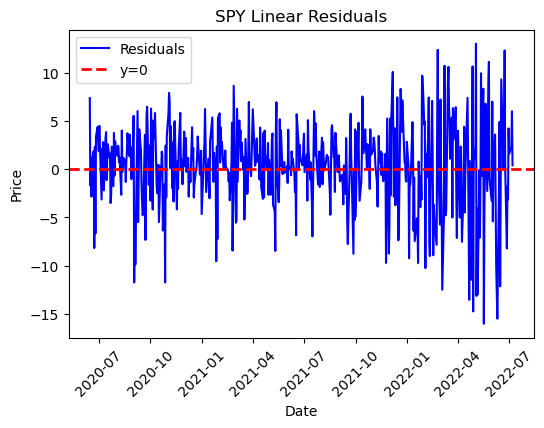

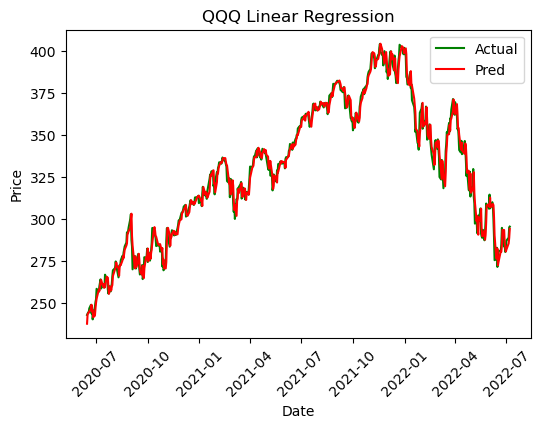

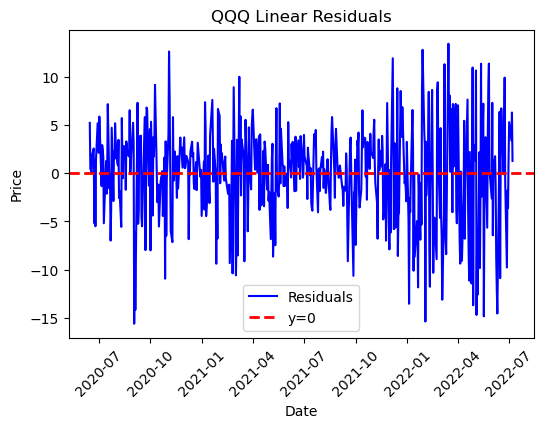

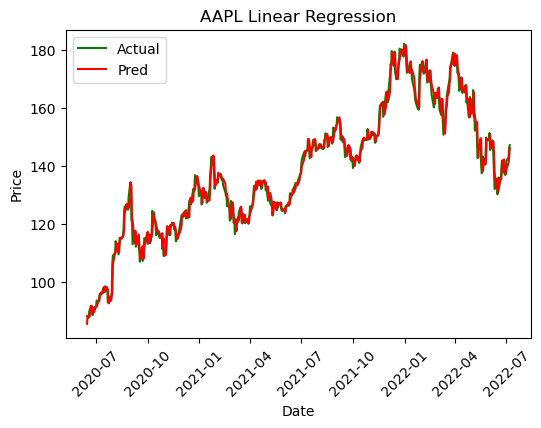

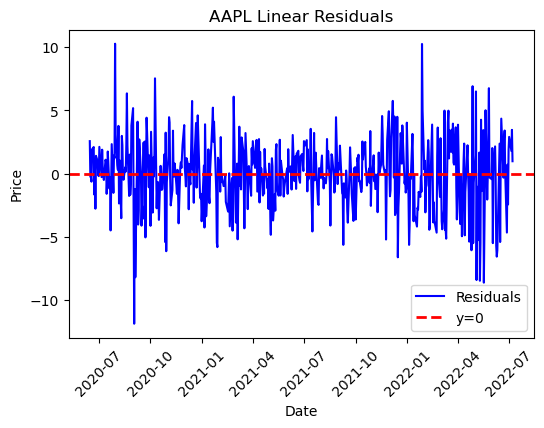

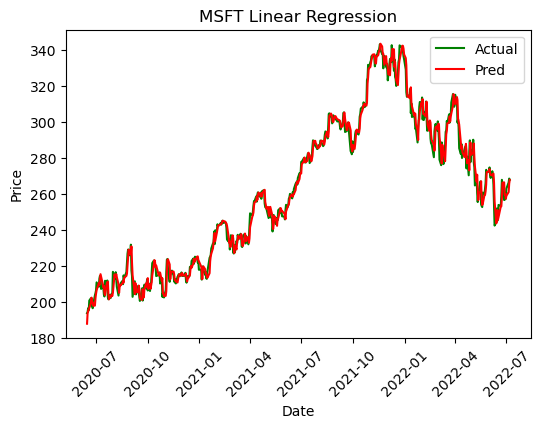

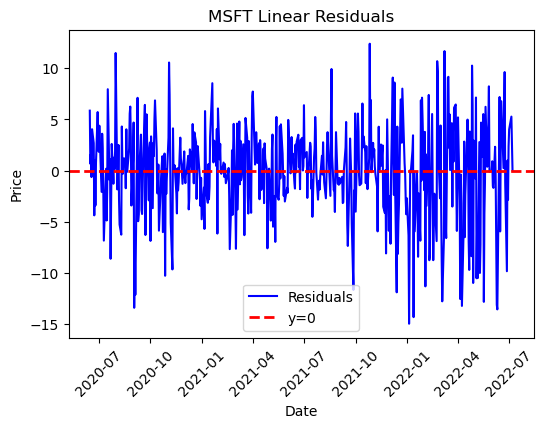

In [11]:
plot_pred(lin_pred, 'Linear')

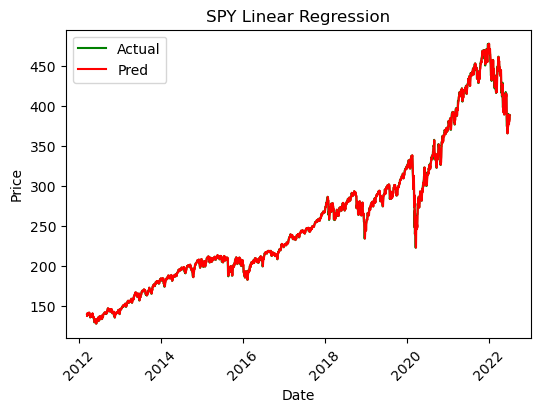

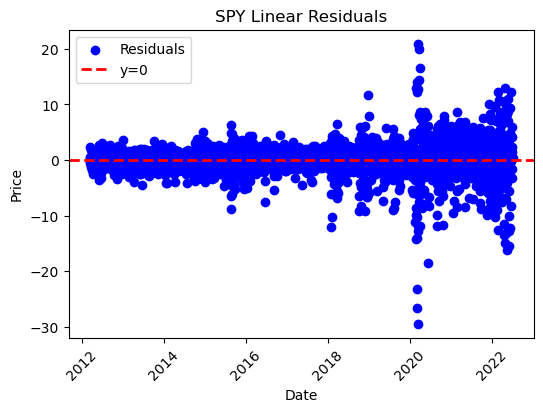

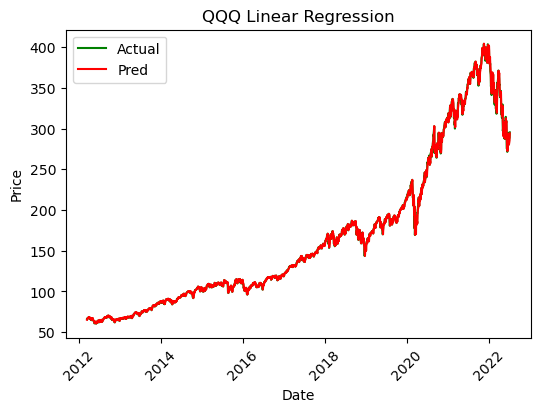

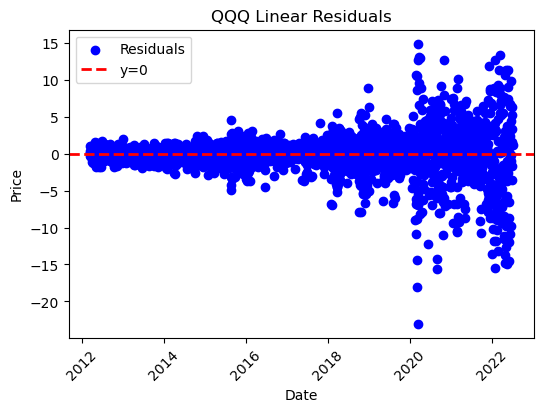

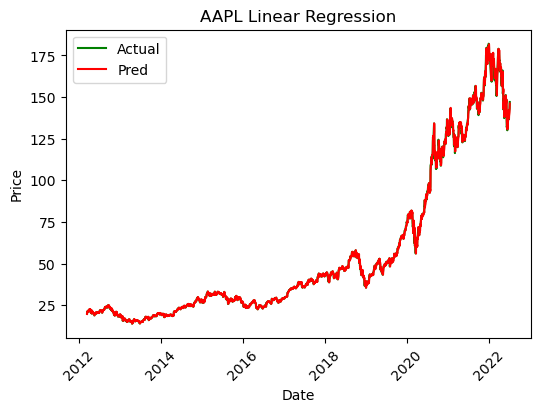

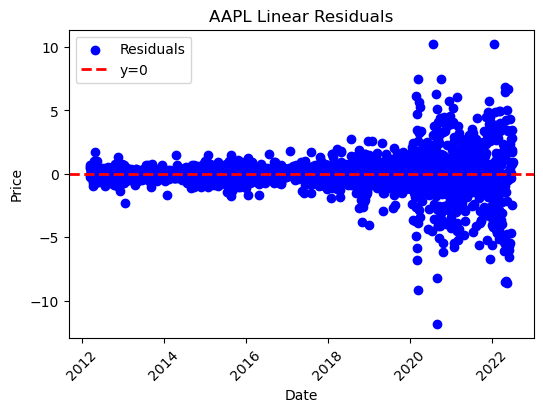

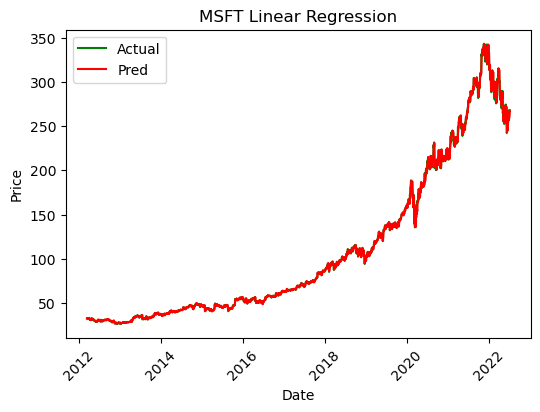

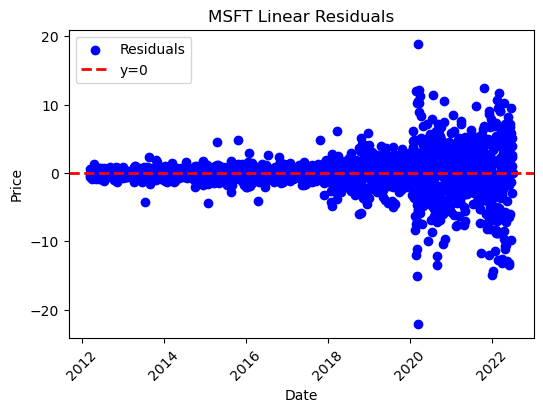

In [12]:
plot_kfold_pred(kfold_lin_pred, 'Linear')

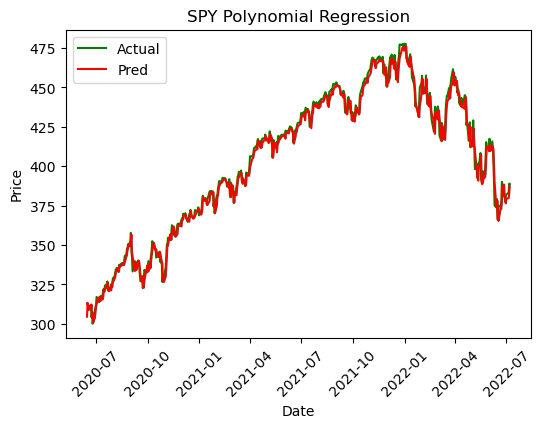

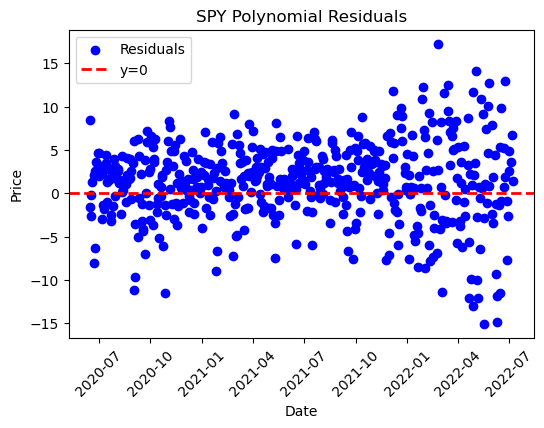

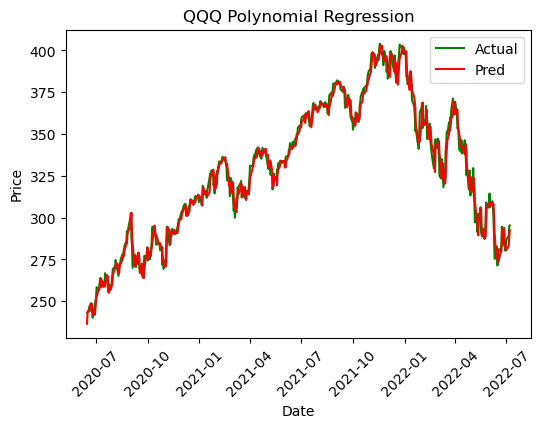

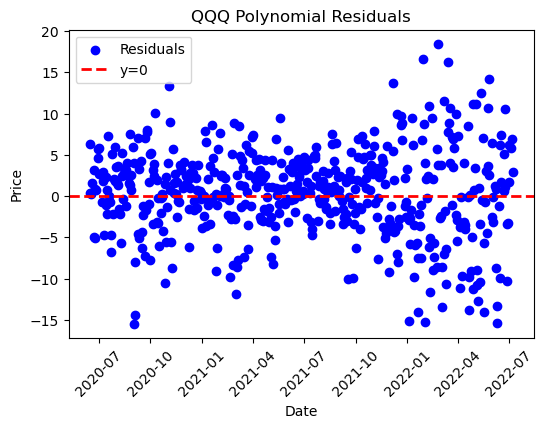

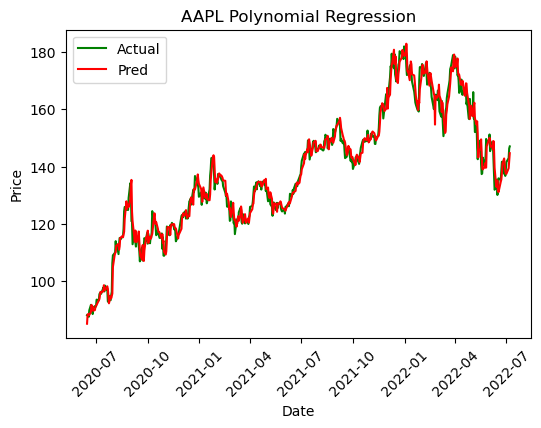

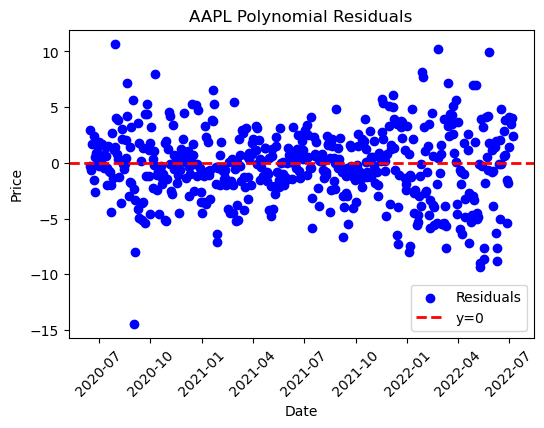

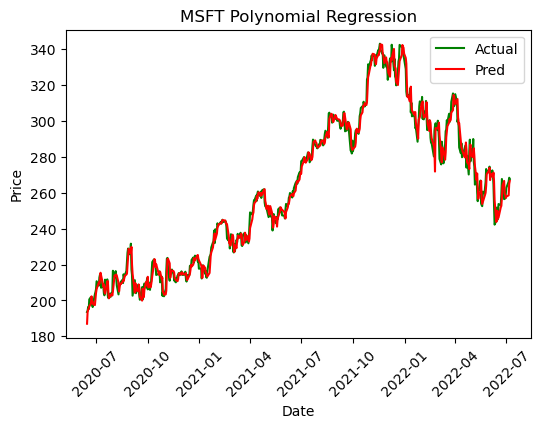

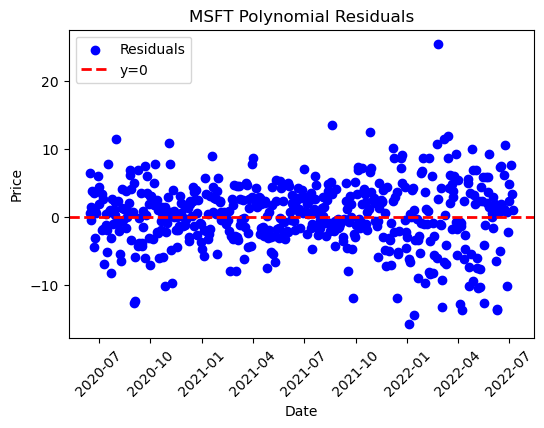

In [15]:
plot_pred(poly_pred, 'Polynomial')